*Do not delete this style setting*

In [1]:
%%html
<style>
table {float:left}
</style>

# Session 2:<br>A Simple Quantum Estimator

<table>
    <tr><td><strong>Aim:</strong></td>
        <td>To explore the creation and use of a simple quantum estimator in <strong>PennyLane</strong><br>
            Note that "simplicity" is only in data and the model structure - not in the approach!</td></tr>
    <tr><td><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td><strong>Release:</strong></td>
        <td>September 2025</td></tr>
    <tr><td><strong>Datasets:</strong></td>
        <td>We will use the following two data set generators from sklearn (code below):<br>
            <ol><li>from sklearn.datasets import <strong><em>make_regression</em></strong> (Workshop)</li>
                <li>from sklearn.datasets import <strong><em>make_swiss_roll</em></strong> or <br>
                    from UCI repository download <strong><em><a href="https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set" target="_blank">Real Estate Valuations</a></em></strong> dataset<br>(requires: ucimlrepo)</li>
            </ol></td></tr>
    <tr><td><strong>Tasks:</strong></td>
        <td>40 minutes (unfinished tasks go to self-directed "challenges")</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at end of this notebook):<br><ol>
            <li>Initially use the <strong><em>Regression</em></strong> dataset 1 (as provided).<br>
                Follow the instructor demonstration to step through the code.</li>
            <li>Can you improve the selected model by:<br>
                - changing entangling methods (basic_ent = False/True) ?<br>
                - changing the number of qubits/wires ?<br>
                - changing the number of training epochs ?<br>
                - changing the optimiser ?<br>
                Which of these changes had the greatest impact on performance?</li>
            <li>Change data encoding by increasing the encoding margin.<br>
                What was the impact of your change? Why do you think it happened ?</li>
            <li>Calculate testing MSE and R2 scores.<br>
                Follow the example of calculating training R2.</li>
            <li>Create a plot of residuals for training and test predictions.<br>
                Note that residuals are (expected-predicted) values.</li>
            <li>Reflect on this session.</li>
        </ol></td>
    </tr>
    <tr>
        <td><strong>Challenge<br>Tasks:</strong></td>
        <td>Perform the following tasks in your own time:<br/>
        <ol style="list-style-type: upper-alpha;">
            <li>Complete the unfinished tasks.</li>
            <li>Change the model by incorporating the reuploading ansatz (see Session 1).</li>
            <li>Create a more insightful visualisation of residuals (research).</li>
            <li>Apply your completed model to either of the following data sets:<br>
                <strong><em>Real Estate Valuations</em></strong> or <strong><em>Swiss Roll</em></strong> (data set 2)<br> 
                - see examples at the end of the notebook<br>
            </li>
        </ol>
        </td>
    </tr>
    <tr><td><strong>References:</strong></td>
        <td><a href="https://www.youtube.com/watch?v=42aa-Ve5WmI" target="_blank">
            Catalina Albornoz, "Optimizing a quantum circuit with PennyLane",<br>PennyLane Tutorial, YouTube Video, Sept 12, 2023.</a></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the
            <a href="https://creativecommons.org/licenses/by/4.0/" target="_blank">Creative Commons CC-BY</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook</td></tr>
</table>

## Libraries

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/lib/python311.zip',
 '/home/jacob/miniconda3/lib/python3.11',
 '/home/jacob/miniconda3/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/venv/pl/lib/python3.11/site-packages',
 '.',
 '..']

In [3]:
### General libraries

import os
import math
import time
import copy
import numpy as nnp # if wanted to use standard numpy
import pandas as pd
from IPython.display import clear_output

import matplotlib.pyplot as plt
from matplotlib import set_loglevel
set_loglevel("warning")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
### Import utilities
from utilities import *

In [5]:
### Import PennyLane
import pennylane as qml
from pennylane import numpy as np # redefined numpy

import plotly.express as px
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, mean_squared_error

---

## <font color="blue">Data preparation</font>
<font color="LightCoral">Task 1: Follow the instructor demonstration to step through the code.</font>

### Data set in its original form

In [6]:
import plotly.io as pio
# The following may preserve the chart on saving
# pio.renderers.default = 'jupyterlab' # or 'notebook'

np.random.seed(42)  # For reproducibility
data_seed = 42
n_samples = 100
n_features = 2

# Generate synthetic regression data
X_raw, y_raw = make_regression(
    n_samples=n_samples,
    n_features=n_features, 
    noise=5.0,
    random_state=data_seed
)
y_raw = y_raw.reshape((y_raw.shape[0], 1))

# Create an interactive 3D scatter plot, of the first two columns
fig = px.scatter_3d(x=X_raw[:, 0], y=X_raw[:, 1], z=y_raw[:, 0], 
                    title='Interactive 3D Scatter Plot',
                    labels={'x': 'Feature x', 
                            'y': 'Feature y', 
                            'z': 'Target'})
mrg = dict(l = 50, r = 50, b = 50, t = 50, pad = 10)
fig.update_traces(marker=dict(size=3, color='CornflowerBlue', symbol='circle'))
fig.update_layout(width=600, height=600, margin = mrg, paper_bgcolor = 'whitesmoke')
fig.show()

---

## <font color="blue">Model development</font>

### Model and training configuration
<font color="LightCoral">Task 2: Experiment with the model size and training hyper-parameters.</font>

- <font color="LightCoral">Change basic to strong entangling method (basic_ent = False)</font>
- <font color="LightCoral">Change the number of qubits/wires _**n_wires**_ (what happens)</font>
- <font color="LightCoral">Change the number of layers _**n_layers**_</font>
- <font color="LightCoral">Change the number of training epochs _**epochs**_</font>

<font color="LightCoral">Task 3: Increase the encoding margin.</font>

- <font color="LightCoral">Change the value of _**x_angle_margin**_ to 0.5.</font>
- <font color="LightCoral">What is the impact of this change? Why?</font>

In [7]:
### Data params used in scaling
#   Encoded values to be scaled to range (0..pi)
#   Optionally, margins can be left out on the value boundaries
x_angle_margin = 0.5 
x_angle_min = 0+x_angle_margin
x_angle_max = np.pi-x_angle_margin

### Architectural parameters
n_wires = n_features+2
n_layers = 4
basic_ent = False
wires = list(range(n_wires))

### Training hyper-parameters
epochs = 80 # 20 # 50 (preferred) # 100 # 300 (long wait)
prompt_fract = 0.05 # Fraction of results shown in training
shots = None # Theoretical results will be computed
seed = 2025

### Prepare data for the quantum classifier

In [8]:
### Standardise X values to the range 0..pi
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_scaler = MinMaxScaler(feature_range=(x_angle_min, x_angle_max)) 
X_scaled = X_scaler.fit_transform(X_raw)
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = y_scaler.fit_transform(y_raw)

In [9]:
### Create data partitions
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, 
                                                    test_size=0.33, random_state=seed, shuffle=False)
print(f'Shapes: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}')

Shapes: X_train=(67, 2), X_test=(33, 2), y_train=(67, 1), y_test=(33, 1)


In [10]:
### Change the data format to tensors
X_train_tens = qml.numpy.tensor(np.array(X_train), requires_grad=False)
y_train_tens = qml.numpy.tensor(np.array(y_train), requires_grad=False)
X_test_tens  = qml.numpy.tensor(np.array(X_test), requires_grad=False)
y_test_tens  = qml.numpy.tensor(np.array(y_test), requires_grad=False)

## Loss and cost function

In [11]:
### Our own gradient-friendly loss function
def mse_cost(targets, predictions):
    cost = 0
    for l, p in zip(targets, predictions):
        cost = cost + (l - p) ** 2
    cost = cost / len(targets)
    return cost

### The cost function generator
def cost_fun_gen(model, cost_fun):
    def _cost_fun(params, inputs, targets):
        nonlocal model, cost_fun
        preds = [model(params, x) for x in inputs]
        return cost_fun(targets, preds)
    return _cost_fun

## PennyLane quantum linear model

In [12]:
### Define device, e.g.
#   default.qubit, lightning.qubit, lightning.gpu

sim = 'default.qubit'
dev = qml.device(sim, wires=n_wires, shots=shots)

print(f'Device to be used:  {sim}\n')

Device to be used:  default.qubit



<font color="CornflowerBlue">PennyLane model optimisation relies on the concept of <strong><em>differentiable programming</em></strong>.<br>
This means that every model component must be a function or its equivalent (e.g. matrix or circuit).<br>
Quantum models presented below are implemented in terms of pure functions.<br>
Such functions do not reference any global variables but take advantage of the <em><strong>nested</strong> or <strong>composite functions</strong></em>.<br>
The higher level function sets the variable scope for the inner function, which is retained.<br>
Optimisation of such models is done by using their function derivatives, which is achieved by the <strong><em>chain rule</em></strong>.<br>
PennyLane has many functions implemented in this way, e.g. functions responsible for circuit drawing.</font>

*Note that the following model has the flexibility of using either basic or strong qubit entanglement.*

In [13]:
### Define a quantum linear model functionally
### This is the PennyLane style of doing things
def qlinear_1(n_wires, n_layers=1, scaler=1.0, basic=False):
    
    def _qlinear(weights, inputs):
        nonlocal n_wires, n_layers, scaler, basic
        data_wires = list(range(n_wires))
        scaled_inputs = inputs * scaler

        # Standard angle encoding block
        qml.AngleEmbedding(scaled_inputs, wires=data_wires)  

        # Ansatz with optional basic or strong entangling block
        if basic:
            qml.BasicEntanglerLayers(weights, wires=data_wires, rotation=qml.RY)
        else:
            qml.StronglyEntanglingLayers(weights, wires=data_wires)
        return qml.expval(qml.PauliZ(0))
        
    return _qlinear

In [14]:
### Full data reuploading model
#   Notes: encoding parameters are intermixed with trainable parameters
#          this model is to be used for the more complex dataset 2
def qlinear_x(params, x):
    for l in range(n_layers):
        for q in range(n_qubits):
            qml.RY(x, wires=q)
        qml.StronglyEntanglingLayers([params[l]], wires=range(n_qubits))
    return qml.expval(qml.PauliZ(0))

def qlinear_2(n_wires, n_layers=1, scaler=1.0, basic=False):
    
    def _qlinear(weights, inputs):
        nonlocal n_wires, n_layers, scaler, basic
        data_wires = list(range(n_wires))
        n_inputs = min(len(inputs), n_wires)
        scaled_inputs = inputs * scaler

        for l in range(n_layers):
            
            # Standard angle encoding block
            qml.AngleEmbedding(scaled_inputs, wires=data_wires)  

            qml.Barrier()
    
            # Ansatz with optional basic or strong entangling block
            if basic:
                qml.BasicEntanglerLayers([weights[l]], wires=data_wires, rotation=qml.RY)
            else:
                qml.StronglyEntanglingLayers([weights[l]], wires=data_wires)
        return qml.expval(qml.PauliZ(0))
        
    return _qlinear

In [15]:
qlinear = qlinear_2

<font color="CornflowerBlue">When we create a complex model, we also need to define a method of calculating its parameters shape.<br>
By turning this method into a function, which could be used wherever is needed, we ensure consistency of shape calculation.<br>
For some basic circuit "patterns", PennyLane provides shape calculating helper functions (as used in here).</font>

In [16]:
### Check the model shape
### This is defined so that we could select and check the shape in one place
def qlinear_shape(n_wires, n_layers=1, basic=False):
    if basic:
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
    else:
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
    return shape

<font color="CornflowerBlue">Note that in contrast with the Session 1 model, we are not using the function decoration to create a model QNode (circuit),<br>
but instead we create the QNode step by step.</font>

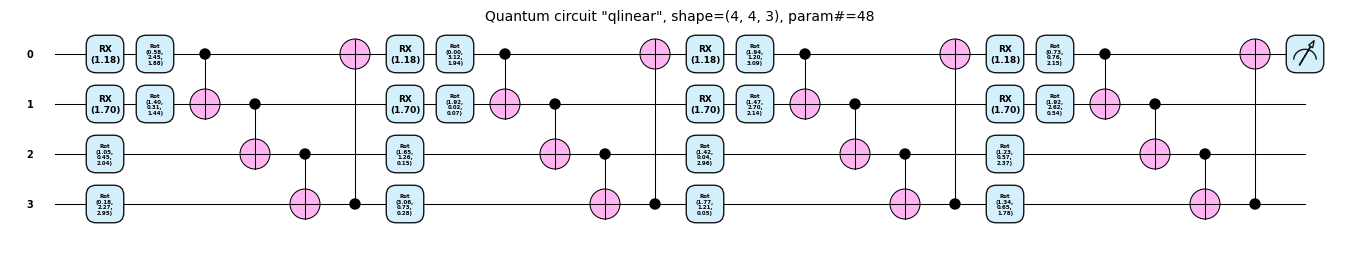

In [17]:
### Create a quantum linear model

# Prepare the quantum linear model and then its qnode (circuit)
qmodel = qlinear(n_wires, n_layers=n_layers, basic=basic_ent)
qlinear_model = qml.QNode(qmodel, dev)
shape = qlinear_shape(n_wires, n_layers=n_layers, basic=basic_ent)

# Plot the model circuit (needs weights and some input)
test_params = np.random.uniform(high=np.pi, size=shape, requires_grad=True)
draw_circuit(qlinear_model, scale=0.5, 
             title=f'Quantum circuit "qlinear", shape={shape}, param#={np.prod(shape)}', 
             level='device')(test_params, X_train_tens[0]) # level='device'/'gradient'

In [18]:
### Test the model
print(f'\nQM weights: {np.prod(shape)}, Epochs: {epochs}')
print(f'\nTest results: {qlinear_model(test_params, X_train_tens[0:5])}\n')


QM weights: 48, Epochs: 80

Test results: [-0.21407116 -0.03487102 -0.02462348  0.06472679  0.09650661]



## Creation and training of the linear model

In [19]:
### Set the random seed
np.random.seed(seed)

### Select a PennyLane optimiser
opt = qml.AdamOptimizer(stepsize=0.5)

### Define the cost function
cost_fun = cost_fun_gen(qlinear_model, mse_cost)

### Initialise the model weights / parameters
params = np.random.uniform(high=np.pi, size=shape, requires_grad=True)

### Training loop
hist_cost = []
hist_params = []
prompt_fract = 0.1
start_time = time.time() 
for iter in range(epochs):
    params, cost = \
        opt.step_and_cost(lambda p: cost_fun(p, X_train_tens, y_train_tens), params)
    hist_cost.append(float(cost))
    hist_params.append(params)
    elapsed_time = time.time()-start_time
    if (prompt_fract == 0) or (iter % int(prompt_fract*epochs) == 0):
        print(f'Iter: {iter:03d} ({int(elapsed_time):03d} sec) '+ \
              f'cost={np.round(cost, 6)}')

Iter: 000 (001 sec) cost=[0.348905]
Iter: 008 (012 sec) cost=[0.062369]
Iter: 016 (023 sec) cost=[0.024727]
Iter: 024 (034 sec) cost=[0.014217]
Iter: 032 (045 sec) cost=[0.006251]
Iter: 040 (056 sec) cost=[0.00188]
Iter: 048 (067 sec) cost=[0.001634]
Iter: 056 (079 sec) cost=[0.001267]
Iter: 064 (090 sec) cost=[0.001007]
Iter: 072 (101 sec) cost=[0.000771]


In [20]:
### Print the training summary
train_mse_hist = hist_cost
train_min_mse = np.min(train_mse_hist)
train_min_mse_iter = np.argmin(train_mse_hist)
print(f'\nTraining completed: epochs={epochs}, '+\
      f'min cost={np.round(train_min_mse, 6)} @ {train_min_mse_iter}, '+\
      f'time={int(elapsed_time):03d} secs\n')


Training completed: epochs=80, min cost=0.000642 @ 79, time=110 secs



## Calculate optimum scores

<font color="CornflowerBlue">Calculate training R2 scores.</font>

- <font color="CornflowerBlue">Note that training MSE has already been generated as part of the cost calculations.</font>
- <font color="CornflowerBlue">We need to calculate MSE score for every model generated in training.</font>
- <font color="CornflowerBlue">All scores will have to be saved in their own history list.</font>
- <font color="CornflowerBlue">Afterwards the maximum R2 (best) and its iteration will be saved as well.</font>
- <font color="CornflowerBlue">Note that model scoring no longer relies on the gradient system (as was the case in the model training),<br>
therefore, we can utilise the *__sklearn__* scoring functions (which do not support gradient calculations).</font>

In [21]:
### Calculate training R2
train_r2_hist = []
train_max_r2 = -float(np.inf)
train_max_r2_iter = -1

# Accumulate R2 scores
for iter in range(len(hist_params)):
    iter_params = hist_params[iter]
    train_pred = qlinear_model(iter_params, X_train_tens)
    curr_r2 = r2_score(y_train_tens, train_pred)
    train_r2_hist.append(float(curr_r2))
    if curr_r2 > train_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter

# Find the optimum training loss and R2
train_max_r2 = np.max(train_r2_hist)
train_max_r2_iter = np.argmax(train_r2_hist)

# Show training results
print(f'\nTraining results: MSE = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}, '+
      f'R2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}\n')


Training results: MSE = 0.0006 @ 0079, R2 = 0.9908 @ 0079



<font color="LightCoral">Task 4: Calculate testing MSE and R2 scores.</font>

- <font color="LightCoral">We need to calculate MSE and R2 scores for every model generated in training.</font>
- <font color="LightCoral">All test scores will have to be saved in their own history list.</font>
- <font color="LightCoral">Afterwards the maximum R2 (best) and minimum MSE (best) test scores will need to be saved<br>together with their respective location.</font>
- <font color="CornflowerBlue">Note that model scoring no longer relies on the gradient system (as was the case in the model training),<br>
therefore, we can utilise the *__sklearn__* scoring functions (which do not support gradient calculations).</font>

In [22]:
### Calculate testing MSE and R2

# Prepare test scores
test_mse_hist = []
test_r2_hist = []

# Initialise testing loss and R2
test_min_mse = float(np.inf)
test_min_mse_iter = -1
test_max_r2 = -float(np.inf)
test_max_r2_iter = -1

# Calculate testing loss and R2
for iter in range(len(hist_params)):
    iter_params = hist_params[iter]
    test_pred = qlinear_model(iter_params, X_test_tens)
    curr_r2 = r2_score(y_test_tens, test_pred)
    curr_mse = mean_squared_error(y_test_tens, test_pred)
    test_r2_hist.append(curr_r2)
    test_mse_hist.append(curr_mse)
    if curr_r2 > test_max_r2:
        test_max_r2 = curr_r2
        test_max_r2_iter = iter
    if curr_mse < test_min_mse:
        test_min_mse = curr_mse
        test_min_mse_iter = iter

# Show test results
print(f'\nTesting results:  MSE = {nnp.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}, '+
      f'R2 = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}\n')


Testing results:  MSE = 0.0013 @ 0062, R2 = 0.9775 @ 0062



## Plot performance and diagnostic charts

### Plot MSE performance

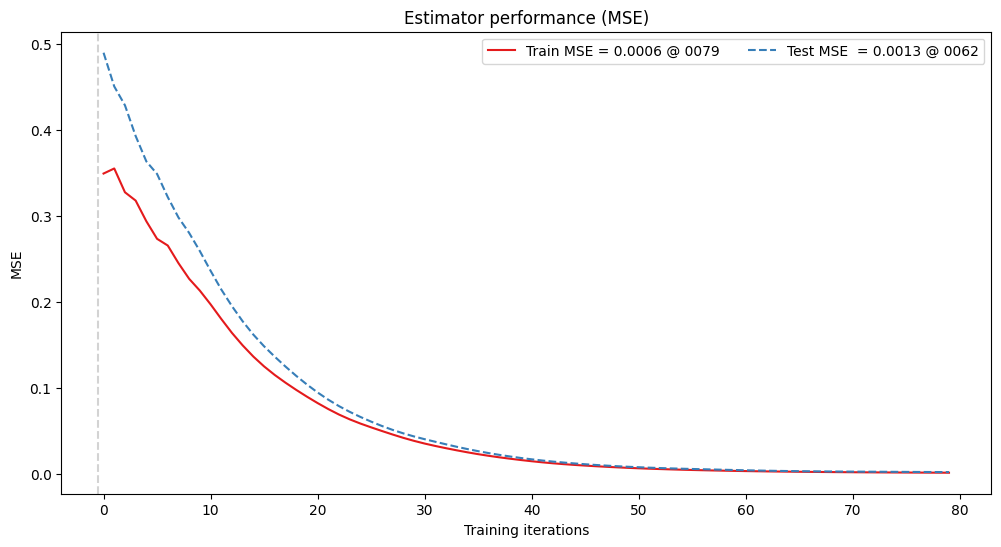

In [23]:
train_label = f'Train MSE = {nnp.round(train_min_mse, 5):05.4f} @ {train_min_mse_iter:04d}'
test_label  = f'Test MSE  = {nnp.round(test_min_mse, 5):05.4f} @ {test_min_mse_iter:04d}'
multi_plot_series(
    [train_mse_hist, test_mse_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='MSE',
    legend_cols=2, smooth_weight=0.9, title='Estimator performance (MSE)'
)

### Plot R2 performance

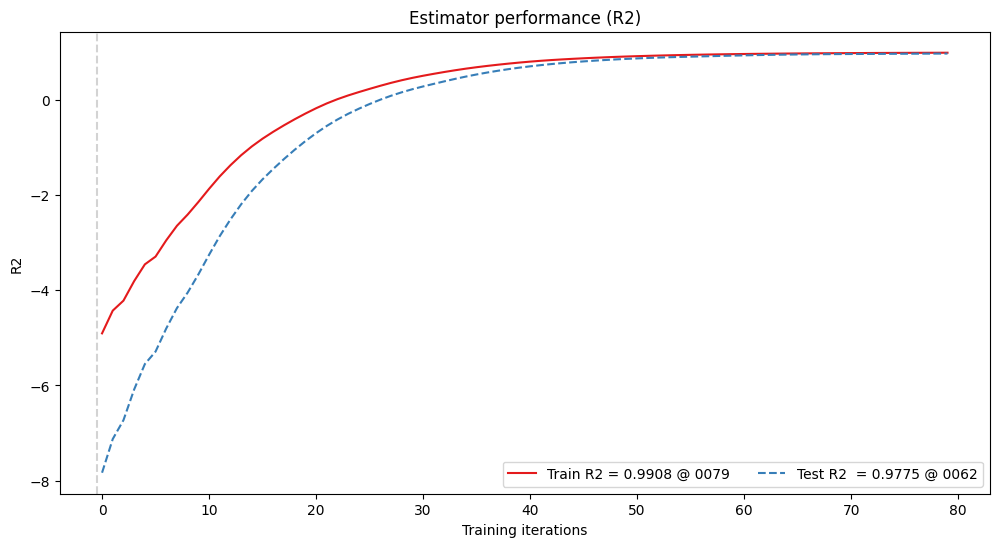

In [24]:
### Plot R2 trainnig and testing scores
train_label = f'Train R2 = {nnp.round(train_max_r2, 5):05.4f} @ {train_max_r2_iter:04d}'
test_label  = f'Test R2  = {nnp.round(test_max_r2, 5):05.4f} @ {test_max_r2_iter:04d}'

multi_plot_series(
    [train_r2_hist, test_r2_hist], X_list=[0, 0], labels=[train_label, test_label], 
    lines=['solid', 'dashed'], # colors=None, markers=None, marker_colors=None,
    rcParams=(12, 6), xlabel='Training iterations', ylabel='R2',
    legend_cols=2, smooth_weight=0.9, title='Estimator performance (R2)'
)

### Plot residuals of the expected vs predicted data
<font color="LightCoral">Task 5. Create a plot of residuals for training and test predictions.</font>

- <font color="LightCoral">Use the best model's parameters to derive predictions for all data.</font>
- <font color="LightCoral">Note that the "best" is based on the minimum MSE test score.</font>
- <font color="LightCoral">Show all results in the original data units of x, y and z axes.</font>
- <font color="LightCoral">Calculate residuals as a percentage of maximum expected values:</font>
  - <font color="LightCoral">Training residuals as a difference between true training z values <strong><em>zt_tr</em></strong> and their prediction <strong><em>z_tr</em></strong>, resulting in <strong><em>dz_tr</em></strong>.</font>
  - <font color="LightCoral">Testing residuals as a difference between true test z values <strong><em>zt_ts</em></strong> and their prediction <strong><em>z_ts</em></strong>, resulting in <strong><em>dz_ts</em></strong>.</font>

In [25]:
### Calculate residuals in the original units (dz=expected-predicted)

# Find the predictions for training and test data
opt_test_params = hist_params[test_min_mse_iter]
y_pred_ts = qlinear_model(opt_test_params, X_test)
y_pred_tr = qlinear_model(opt_test_params, X_train)

# Rescale all data to the original units
y_pred_org_ts = y_scaler.inverse_transform(y_pred_ts.reshape((y_pred_ts.shape[0], 1)))
y_true_org_ts = y_scaler.inverse_transform(y_test.reshape((y_test.shape[0], 1)))
z_ts, zt_ts = y_pred_org_ts.reshape((y_pred_org_ts.shape[0])), y_true_org_ts.reshape((y_true_org_ts.shape[0]))
y_pred_org_tr = y_scaler.inverse_transform(y_pred_tr.reshape((y_pred_tr.shape[0], 1)))
y_true_org_tr = y_scaler.inverse_transform(y_train.reshape((y_train.shape[0], 1)))
z_tr, zt_tr = y_pred_org_tr.reshape((y_pred_org_tr.shape[0])), y_true_org_tr.reshape((y_true_org_tr.shape[0]))

# Calculate residuals (true-predicted) normalised to the range of values 
z_range = np.max([np.abs(np.min(zt_ts)), np.abs(np.max(zt_ts)), np.abs(np.min(zt_tr)), np.abs(np.max(zt_tr))])
dz_ts = (zt_ts-z_ts)*100 / z_range
dz_tr = (zt_tr-z_tr)*100 / z_range

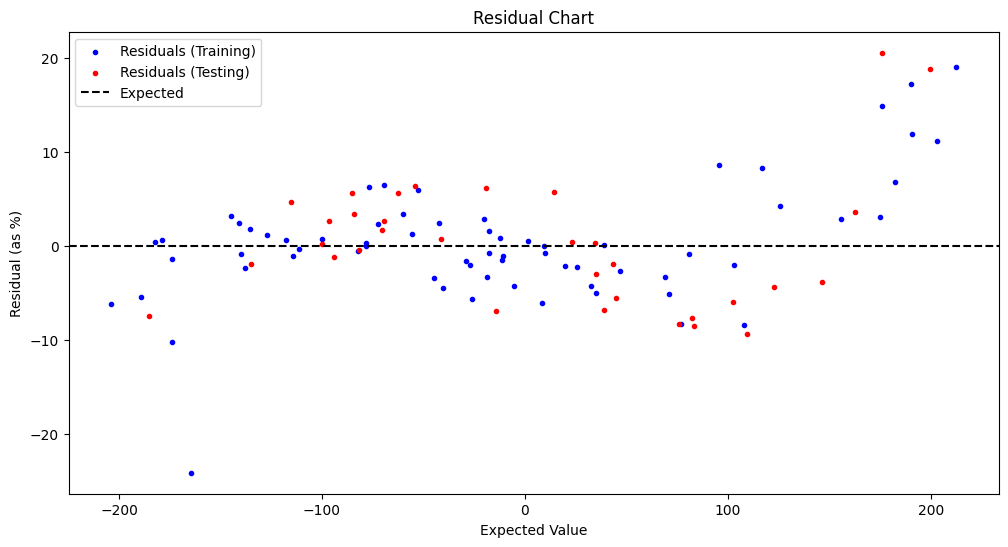

In [26]:
### Plot residuals
plt.title('Residual Chart')
plt.xlabel('Expected Value')
plt.ylabel('Residual (as %)')
plt.scatter(x=zt_tr, y=dz_tr, marker='.', color='blue', label='Residuals (Training)')
plt.scatter(x=zt_ts, y=dz_ts, marker='.', color='red', label='Residuals (Testing)')
plt.axhline(0, linestyle='--', color='black', label='Expected')
plt.legend(loc='best', ncol=1)
plt.show()

**Residuals chart at the start (initial model)** (delete it after generating your charts)

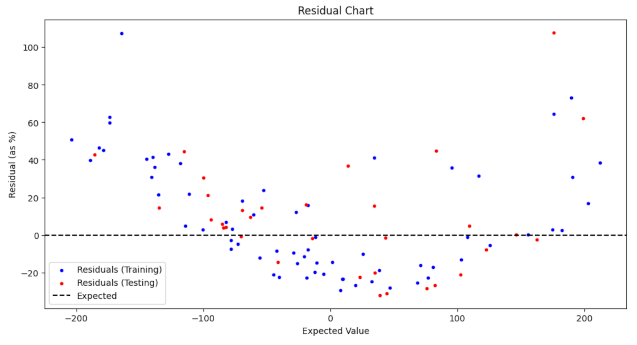

### Residuals histograms

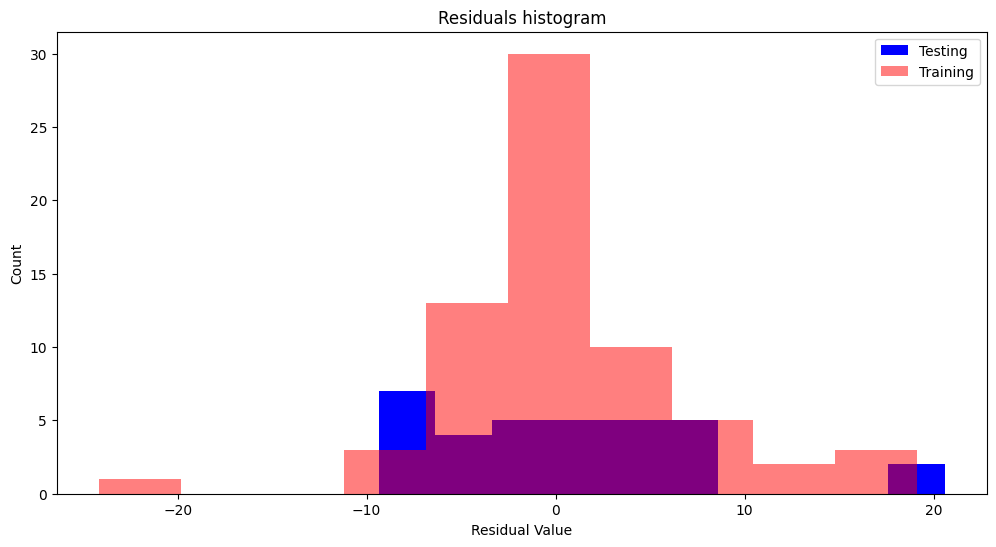

In [27]:
plt.title('Residuals histogram')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.hist(dz_ts, bins=10, label='Testing', color='blue')
plt.hist(dz_tr, bins=10, alpha=0.5, label='Training', color='red')
plt.legend()
plt.show()

### Plot truth vs prediction

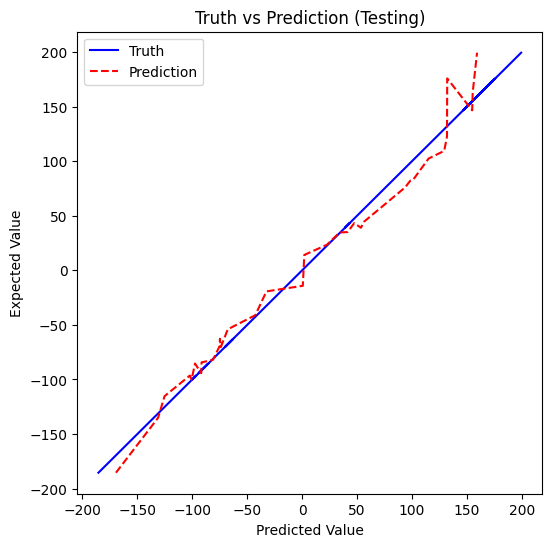

In [28]:
### Plot residuals
# y_pred_org_ts - Testing predictions
# y_true_org_ts - Actual test values 

df = pd.DataFrame({'x': y_pred_org_ts.reshape((y_pred_org_ts.shape[0], )), 
                   'y': y_true_org_ts.reshape((y_true_org_ts.shape[0], ))})
df = df.sort_values('x')
x = df['x'].to_numpy(); y = df['y'].to_numpy()

plt.rcParams["figure.figsize"] = (6, 6)
plt.title('Truth vs Prediction (Testing)')
plt.xlabel('Predicted Value')
plt.ylabel('Expected Value')
plt.plot(y, y, ls='-', color='blue', label='Truth')
plt.plot(x, y, ls='--', color='red', label='Prediction')
# plt.axhline(0, linestyle='--', color='black', label='Expected')
plt.legend(loc='best', ncol=1)
plt.show()

---

## <font color="blue">Challenge task:</font><br>Apply your model to the Swiss Roll data set 2 (in own time)

In [29]:
from sklearn.datasets import make_swiss_roll

np.random.seed(42)
data_seed = 42
n_samples = 1000 # Reduce to 300
noise = 0.2

X_raw, y_raw = make_swiss_roll(
    n_samples=n_samples,
    noise=0,
    random_state=data_seed,
    hole=False # With the hole it is harder
)

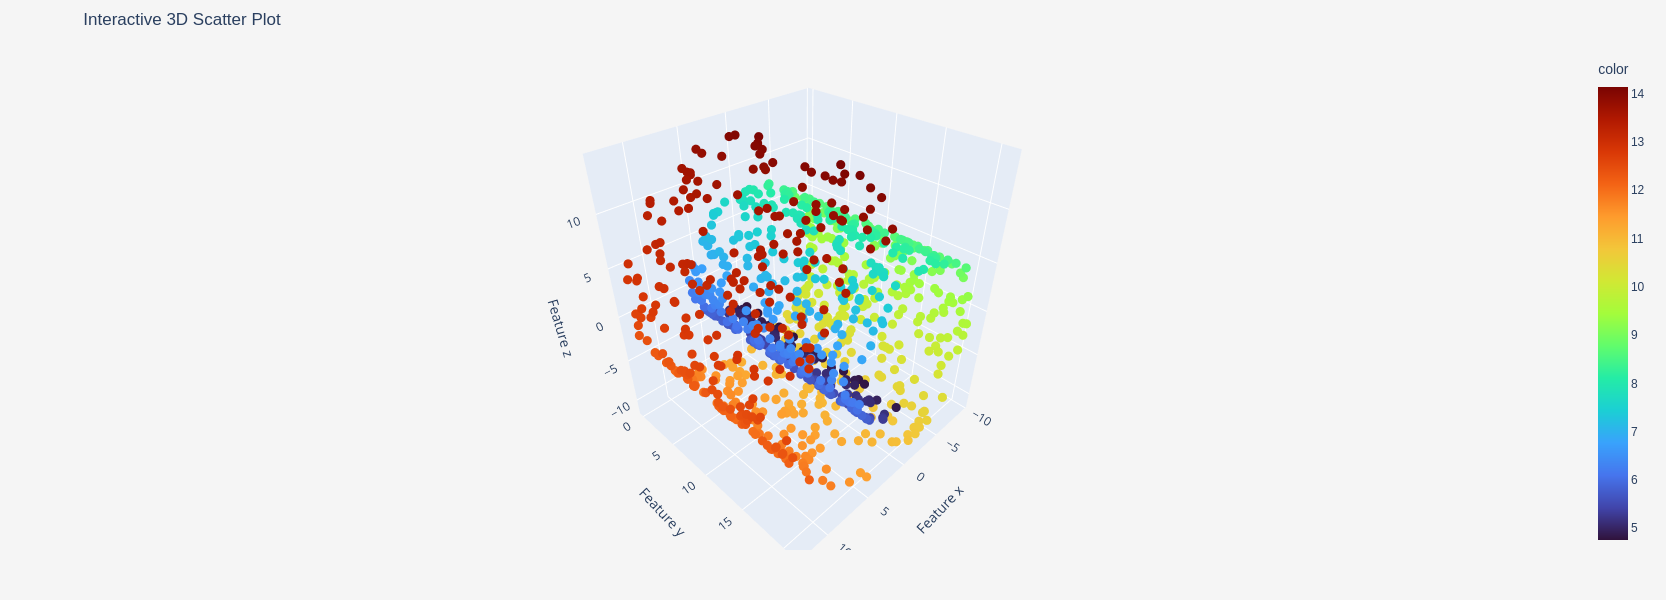

In [30]:
import plotly as ply
import plotly.express as px
import plotly.io as pio
# The following may preserve the chart on saving
# pio.renderers.default = 'jupyterlab' # or 'notebook'

# Create an interactive 3D scatter plot, of the first two columns
fig = px.scatter_3d(x=X_raw[:, 0], y=X_raw[:, 1], z=X_raw[:, 2], 
                    title='Interactive 3D Scatter Plot',
                    labels={'x': 'Feature x', 
                            'y': 'Feature y', 
                            'z': 'Feature z'},
                    color=y_raw, 
                    color_continuous_scale = ply.colors.sequential.Turbo)
mrg = dict(l = 50, r = 50, b = 50, t = 50, pad = 10)
fig.update_traces(marker=dict(size=3, symbol='circle'))
fig.update_layout(width=600, height=600, margin = mrg, paper_bgcolor = 'whitesmoke')
fig.show()

---

## Write your observations here

- Task 1 - run:
  - q=2, l=5, be=T, ep=50 → tr(MSE = 0.0222, R2 = 0.6798)<br>
    Our reference, Not bad
- Task 2 - experiments with consecutive changes:
  - (a) Entanglement - cell 7, line 11, basic_ent = False<br>
    q=2, l=5, be=F, ep=050 → tr(MSE = 0.0049, R2 = 0.9342) *<br>
    Order of magnitude better
  - (b) Qubits - cell 7, line 11, n_wires = 4<br>
    q=4, l=5, be=F, ep=050 → tr(MSE = 0.0010, R2 = 0.9851) *<br>
    Significant improvement in both MSE and R2
  - (c) Layers - cell 7, line 11, n_wires = 2, n_layers=7<br>
    q=2, l=7, be=F, ep=50 → tr(MSE = 0.0032, R2 = 0.9542)<br>
    In this case, increasing no of layers did not improve performance
  - (d) Epochs - cell 7, line 11, n_layers=5, epochs=100<br>
    q=2, l=5, be=F, ep=100 → tr(MSE = 0.0025, R2 = 0.9638) *<br>
    At 50 epochs MSE was still going down, increase to 100 improved MSE
  - (e) Optimiser (GD, RMSProp, Nesterov) - cell 17, lines 5-9, opt=Nesterov<br>
    q=2, l=5, be=F, ep=100 → tr(MSE = 0.0025, R2 = 0.9634)<br>
    GD, RMSProp worse, Nesterov on  par, Adam best
  - (f) Best? - cell 7, line 11, n_wires=4, epochs=100..200; cell 17, lines 6,9, opt=Adam<br>
    q=4, l=5, be=F, ep=200 → tr(MSE = 0.0024, R2 = 0.9649)<br>
    No improvement, so more and larger ≠ better, rewind!
- Task 3 - change data encoding:
  - cell 7, line 4, x_angle_margin = 0.5 (reduce encoding range)<br>
    q=2, l=5, be=F, ep=100 → tr(MSE = 0.0008, R2 = 0.9884) *<br>
    greatest impact on performance!
- Task 4 - add MSE and R2 testing scores, now we can also plot:
  - Training results: MSE = 0.0008 @ 0099, R2 = 0.9884 @ 0098
  - Testing  results: MSE = 0.0011 @ 0065, R2 = 0.9795 @ 0065
  - While the model is still learning, its ability to generalise stops much earlier
  - Performance plots for training and testing were very useful, especially when applied to the earlier (retrofitted) and later stages (final) of this development. It seems that even the initial model had a great potential and over its improvement stages the performance increased only marginally.
- Task 5 - added calculation of residuals in the original data units:
  - cells 22-23 modified in stages:
    - Found the predictions for training and test data
    - Added scatter plot of expected value vs residual (expected - predicted), with horiz line for zero
    - Inverted previously applied scaling (y_scaler.inverse_transform) for training and test, predictions and true data
  - The residuals plots were quite revealing. At the beginning of this development (included as image) residuals were up to 60% (with outliers of 100%) of data values, after all improvements, the majority of residuals are within 10% of data values (with outliers not exceeding 20%). So, the model performance has visibly improved overall.
- Challenge: Your creativity rules the world!
- Reflection: We have conducted a lot of experiments, which resulted in a greatly improved model. In practice, it would be much better to automate running of these experiments. This would (most likely and unfortunately) require abandoning notebooks, implementating the base code in python, parameterising it, and scheduling the experiments to be run in batch. The following tools could assist in such experiments: Kedro, MLflow, Dask, or even simpler Sacred and Hydra.

## Software (Linux)

In [31]:
import os
os.system('pip list | grep -e pennylane');

pennylane                 0.42.3
pennylane_lightning       0.42.0
